In [5]:
import lmfit
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import matplotlib
from mantid.simpleapi import *
import matplotlib.patheffects as PathEffects
import matplotlib.patheffects as PathEffects
cwd=os.getcwd()
sys.path.append("../python scripts/")
from import_material_cif import *

from nxspetomd import *
from genslices import *
import MDUtils as mdu
from getcolor import *
from cut_mdhisto_powder import *
from mdfactorization import *
from trapzerr import *
from mask_minQ import *
from maskQEbox import *
#Style sheet updates
plt.rcParams['xtick.direction']='in'
plt.rcParams['ytick.direction']='in'
plt.rcParams['xtick.minor.visible']=True
plt.rcParams['ytick.minor.visible']=True
plt.rcParams['xtick.top']=True
plt.rcParams['ytick.right']=True
plt.rcParams['font.size']=10
plt.rcParams['xtick.labelsize']=10
plt.rcParams['ytick.labelsize']=10
plt.rcParams['text.usetex']=False
plt.rcParams['font.family']='serif'
plt.close('all')
%matplotlib notebook

/home/tom/anaconda3/envs/mantid/lib/python3.6/site-packages/h5py/__init__.py:40: UserWarning: h5py is running against HDF5 1.10.0 when it was built against 1.10.6, this may cause problems
  '{0}.{1}.{2}'.format(*version.hdf5_built_version_tuple)


## This notebook is to derive the normalization factor used for the HYS data. It uses the same methodology as the MACS notebook, but with small differences due to time of flight.


In [6]:
qslice_hys = GenQslice(0,3,120)
eslice_hys = GenEslice(-20,20,80)

nsf_f = 'HLIO_tot_NSF.nxspe'
nsfws = LoadNXSPE(nsf_f)

#Workspace imported, create material object for structure factor calculation again.

cifname = cwd+'/D3LiIr2O6.CIF'
alcifname = cwd+'/Aluminum.cif'
nist_file = cwd+'/nist_scattering_table.txt'

b_arr={}
b_arr['D']=['---','6.67','4.04','5.592','2.05','7.62','0'][1]
b_arr['H']=['---','-3.759','---','1.7568','80.26','82.03','0'][1]

b_arr['Li']=['92.5','-2.22','-2.49','.619','0.78','1.4','0.0454' ][1]
b_arr['Ir']=['---', '13.0', '---', '14.1', '0.(3.)', '14.(3.)', '425.(2.)'][1]
b_arr['O']='5.8'
abs_191 = 954.0
abs_193 = 111.0
abs_Ir =0.95*abs_193 + 0.05*abs_191
abs_dict_LIO ={'Li':0.454,'Ir':abs_Ir,'O':0.00019,'H':0.0}
HLIO=Material(cifname,suppress_print=True,nist_data=nist_file,b_arr=b_arr)
HLIO.formula_weight=494.3

 Material.formula_weight=(val)



In general, the intensity from a structural Bragg peak is given by

$I_{bragg}(Q,\omega)=N\frac{(2\pi)^3}{V_0}\sum|F_{HKL}(Q)|^2 $

For a powder,


$\int 4\pi Q^2 I(Q,\omega) dQ d\omega = {\cal A}N\frac{(2\pi)^3}{V_0}|F_{HKL}(Q)|^2$

Where ${\cal A}$ is a normalization factor that may be fit. If we are normalizing to per unit cell and are only using a single-energy cut, then the expression becomes

$I(Q) = {\cal A}\frac{(2\pi)^3}{V_0}\frac{|F_{HKL}(Q)|^2}{4\pi Q^2}$

Where we have integrated over the energy dimension. The quantity ${\cal A}$ is now fit.

In [16]:
nsfmd = ConvertToMD(nsfws,Qdimensions='|Q|')
nsf_el = BinMD(nsfmd,AlignedDim0='|Q|,0.4,2.0,60',AlignedDim1='DeltaE,-2,2,1')
#Right now it is integrated in meV, convert to per eV
nsf_el /=1e3
#Absorption factor for elastic line Ei=20 meV neutrons:
abs = HLIO.calc_sample_absorption(Ei=20.0,deltaE=0.0,d_eff=0.1,abs_dict=abs_dict_LIO,suppress_print=False)
print(f"Overall elastic absorption coefficient: {abs:.2f}")
nsf_el /=abs

Mean elastic path length for Ei=20.0meV = 0.33 cm
Overall elastic absorption coefficient: 0.74


Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


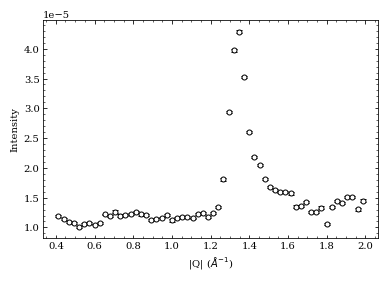

In [17]:
# Make a sanity check plot.
%matplotlib inline
fig, ax = plt.subplots(1,1,subplot_kw={'projection':'mantid'})
ax.errorbar(nsf_el,capsize=3,ls=' ',color='k')

fig.show()

In [18]:
# Generate structure factors per unit cell
def gen_reflection_list(material, max_index=20, maxQmag=1e10, b_dict=False, min_SF=1e-3):
    #Calculates the structure factor for all reflections in the unit cell.
    # returns an array of arrays of format [H K L Freal Fi |F|^2 ]
    #Returns in units of per unit cell
    structure = material.gen_unit_cell_positions()

    F_HKL = 0.0
    #Generate array of Q-vectors
    taulim = np.arange(-max_index + 1, max_index)
    xx, yy, zz = np.meshgrid(taulim, taulim, taulim)
    x = xx.flatten()
    y = yy.flatten()
    z = zz.flatten()
    #array of reciprocal lattice vectors; 4th column will be structure factor^2
    tau = np.array([x, y, z, np.zeros(len(x))]).transpose()

    ion_list = np.array(structure)[:, 0]
    occupancy_arr = np.array(structure)[:, 5].astype(float)
    b_array = occupancy_arr * np.array(structure)[:, 1].astype(float)

    #Imported from the NIST site so this is in femtometers, for result to be barn divide by 10
    b_array = b_array * 0.1

    unit_cell_pos = np.array(structure)[:, 2:5].astype(float)

    a_vec = material.avec
    b_vec = material.bvec
    c_vec = material.cvec
    u_vec = material.u
    v_vec = material.v
    w_vec = material.w

    i = 0
    bad_ind = []
    for i in range(len(tau)):
        q_vect = tau[i][0:3]
        qmag = material.Qmag_HKL(q_vect[0], q_vect[1], q_vect[2])

        if qmag > maxQmag:
            bad_ind.append(i)
            tau[i, 3] = 0.0
        else:
            SF = 0
            #Sum over all ions in the cell
            for j in range(len(unit_cell_pos)):
                pos = unit_cell_pos[j]
                SF = SF + occupancy_arr[j] * b_array[j] * np.exp(-2.0j * np.pi * np.inner(q_vect, pos))
            tau[i, 3] = np.linalg.norm(SF) ** 2
    # Eliminate tiny values
    tau[:, 3][tau[:, 3] < 1e-8] = 0.0
    low_reflect_i = np.where(tau[:, 3] == 0.0)[0]
    zero_ind = np.where(tau[:, 3] == 0.0)[0]
    tau = tau[tau[:, 3] > min_SF]
    material.HKL_list = tau
    return tau


reflist = gen_reflection_list(HLIO, maxQmag=3.0)

Structure factors for low-Q reflections in D3LiIr2O6
H    K    L    |Q|    |SF|^2
0    0    0    0.00   137.265
0    2    0    1.36   23.804
0    0    1    1.39   67.307
1    1    0    1.43   46.533
1    1    1    1.64   42.649
0    2    1    1.94   33.305
1    1    1    2.29   41.613
2    0    1    2.39   2.306
1    3    0    2.40   4.057
2    0    0    2.52   114.857
1    3    1    2.53   229.734
1    1    2    2.68   29.866
0    4    0    2.72   8.994
2    2    1    2.75   19.689
0    0    2    2.77   7.072
2    2    0    2.87   31.049
2    0    2    2.99   0.084
1    3    1    2.99   0.141


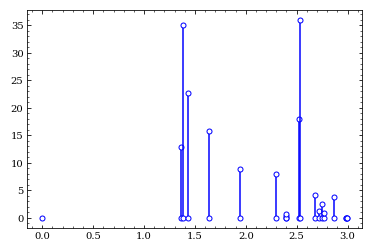

In [19]:
#Combine the reflections with the same |Q| values
powder_reflist = []
qlist = []
hkllist=[]
sflist = []
for i,ref in enumerate(reflist):
    h,k,l=ref[0],ref[1],ref[2]
    Q = HLIO.Qmag_HKL(h,k,l)
    qlist.append(Q)
    hkllist.append([h,k,l])
    sflist.append(ref[3])
qlist = np.around(qlist,3) #Assume resolution of 0.01 Ang^-1
hkllist=np.array(hkllist)
sflist=np.array(sflist)
#organize all of this into a final array with columns [h,k,l,|Q|,SF^2]
hklQsf=[]
for q in np.unique(qlist):
    q_i = np.where(qlist==q)[0]
    sf = np.sum(sflist[q_i])
    hkl=np.abs(hkllist[q_i])[0]
    hklQsf.append([hkl[0],hkl[1],hkl[2],q,sf])

fig,ax =plt.subplots(1,1)
print('Structure factors for low-Q reflections in D3LiIr2O6')
print('H    K    L    |Q|    |SF|^2')
for i in range(len(hklQsf)):
    entry = hklQsf[i]
    print(f"{entry[0]:.0f}    {entry[1]:.0f}    {entry[2]:.0f}    {entry[3]:.2f}   {entry[4]:.3f}" )

    ax.plot([entry[3],entry[3]],[0,entry[4]/entry[3]**2],color='b',ls='-')

In [20]:
#Now develop a simple model of scattering to get normalizaion constant.

def gaussian(x,sf,x0,sigma):
    return (sf/(np.sqrt(2.0*np.pi)* sigma))*np.exp(-(x-x0)**2 / (2.0*sigma**2))

params=lmfit.Parameters()
#Assume the form of a gaussian near each peak, scaled by the appropriate prefactors.
#The widths of these peaks should all be the same.
params.add('sigma',value=0.035,min=0.01,max=0.07)
params.add('inc_b',value=1e-3,min=0,max=1e4,vary=True) #also add linear background for incoherent scattering
params.add('Ascale',value=1e3,min=0.000,max=1e6)
params.add('delta',value=0.0,min=-0.1,max=0.1,vary=True)#Allow overall shift from misalignment
for i in range(len(hklQsf)):
    entry = hklQsf[i]
    hklstr = f"{entry[0]:.0f}"+'_'+f"{entry[1]:.0f}"+'_'+f"{entry[2]:.0f}"
    params.add('SF_'+hklstr,value=entry[4],vary=False)
    params.add('X0_'+hklstr,value=entry[3],vary=False)

def calc_powderline(params,q,hkllist,material):
    #Expects hkllist to have [h,k,l,Q,SF^2]
    I_out = np.zeros(len(q))
    sigma = params['sigma'].value
    scale = params['Ascale'].value
    inc_b = params['inc_b'].value
    delta=params['delta'].value
    for hkl_entry in hkllist:
        hklstr = f"{hkl_entry[0]:.0f}"+'_'+f"{hkl_entry[1]:.0f}"+'_'+f"{hkl_entry[2]:.0f}"
        q0 = params['X0_'+hklstr].value
        sf = params['SF_'+hklstr].value
        V0 = material.cell_vol
        prefactor = (2.0*np.pi)**3 / (4.0*np.pi*V0)
        #Normalization factor
        prefactor*=scale
        I_peak = gaussian(q-delta,sf,q0,sigma)
        I_peak*=prefactor
        #Account for powder averaging
        I_peak/=q**2
        I_out+=I_peak
    I_out+=inc_b/(4.0*np.pi)
    return I_out

def chisqr(params,q,icut,err,hkllist,material):
    pow_calc = calc_powderline(params,q,hkllist,material)
    chisqr_list = np.abs(icut-pow_calc)**2 / (err**2)
    print(f"icut {np.shape(icut)}")
    print(f"chisqr_list {np.shape(chisqr_list)}")
    print(f"err {np.shape(err)}")
    c2 = np.nanmean(chisqr_list)
    return c2
#minimize chisqr
dims = nsf_el.getNonIntegratedDimensions()
q = mdu.dim2array(dims[0])
i = nsf_el.getSignalArray()/nsf_el.getNumEventsArray()
i = i[:,0]
err = np.sqrt(np.copy(nsf_el.getErrorSquaredArray()))/nsf_el.getNumEventsArray()
err=err[:,0]
result = lmfit.minimize(chisqr,params,method='powell',kws={'q':q,'icut':i,'err':err,'hkllist':hklQsf,'material':HLIO})

icut (60,)
chisqr_list (60,)
err (60,)
icut (60,)
chisqr_list (60,)
err (60,)
icut (60,)
chisqr_list (60,)
err (60,)
icut (60,)
chisqr_list (60,)
err (60,)
icut (60,)
chisqr_list (60,)
err (60,)
icut (60,)
chisqr_list (60,)
err (60,)
icut (60,)
chisqr_list (60,)
err (60,)
icut (60,)
chisqr_list (60,)
err (60,)
icut (60,)
chisqr_list (60,)
err (60,)
icut (60,)
chisqr_list (60,)
err (60,)
icut (60,)
chisqr_list (60,)
err (60,)
icut (60,)
chisqr_list (60,)
err (60,)
icut (60,)
chisqr_list (60,)
err (60,)
icut (60,)
chisqr_list (60,)
err (60,)
icut (60,)
chisqr_list (60,)
err (60,)
icut (60,)
chisqr_list (60,)
err (60,)
icut (60,)
chisqr_list (60,)
err (60,)
icut (60,)
chisqr_list (60,)
err (60,)
icut (60,)
chisqr_list (60,)
err (60,)
icut (60,)
chisqr_list (60,)
err (60,)
icut (60,)
chisqr_list (60,)
err (60,)
icut (60,)
chisqr_list (60,)
err (60,)
icut (60,)
chisqr_list (60,)
err (60,)
icut (60,)
chisqr_list (60,)
err (60,)
icut (60,)
chisqr_list (60,)
err (60,)
icut (60,)
chisqr_list (6

In [21]:
np.shape(err)

(60,)

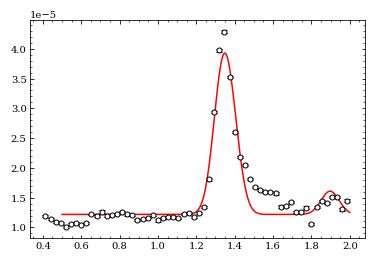

In [22]:
A = result.params['Ascale'].value
evalQ = np.linspace(0.5,2.0,1000)

evalresult = calc_powderline(result.params,q=evalQ,
                             hkllist=hklQsf,material=HLIO)
#evalresult/=A

fig,ax = plt.subplots(1,1)
#.errorbar(nsf_el,color='k')
ax.errorbar(q,i,yerr=err,color='k')
ax.plot(evalQ,evalresult,'r-')

In [23]:
datscale = 1.0/A
datscale = datscale/3.0 #total NSF channel has 3x bragg xc
finalscale = datscale/4.0 #per ir
print(finalscale)

148530.70899279363


In [24]:
print(lmfit.fit_report(result))

[[Fit Statistics]]
    # fitting method   = Powell
    # function evals   = 628
    # data points      = 1
    # variables        = 4
    chi-square         = 11727.7541
    reduced chi-square = -3909.25136
    Akaike info crit   = 17.3697135
    Bayesian info crit = 9.36971346
[[Variables]]
    sigma:     0.04666507 (init = 0.035)
    inc_b:     1.5309e-04 (init = 0.001)
    Ascale:    5.6105e-07 (init = 1000)
    delta:    -0.04139950 (init = 0)
    SF_0_0_0:  137.2647 (fixed)
    X0_0_0_0:  0 (fixed)
    SF_0_2_0:  23.80384 (fixed)
    X0_0_2_0:  1.36 (fixed)
    SF_0_0_1:  67.30745 (fixed)
    X0_0_0_1:  1.385 (fixed)
    SF_1_1_0:  46.53301 (fixed)
    X0_1_1_0:  1.433 (fixed)
    SF_1_1_1:  41.61319 (fixed)
    X0_1_1_1:  2.292 (fixed)
    SF_0_2_1:  33.30469 (fixed)
    X0_0_2_1:  1.941 (fixed)
    SF_2_0_1:  2.306483 (fixed)
    X0_2_0_1:  2.394 (fixed)
    SF_1_3_0:  4.057037 (fixed)
    X0_1_3_0:  2.398 (fixed)
    SF_2_0_0:  114.8569 (fixed)
    X0_2_0_0:  2.524 (fixed)
    